In [45]:
import decimal

import matplotlib.pyplot as plt
import numpy
import pandas as pd
import scipy.sparse
import scipy.special
import scipy.stats
import tqdm

In [6]:
import hetmech.hetmat
import hetmech.degree_group
import hetmech.degree_weight
import hetmech.pipeline

In [7]:
hetmat = hetmech.hetmat.HetMat('../data/hetionet-v1.0.hetmat/')

In [8]:
metapaths = ['DaGbC', 'GpBPpGiG', 'GeAeG',]

In [140]:
metapath = metapaths[0]

In [228]:
# Used in the next cell
def matrix_to_dgp(matrix, dwpc_scaler, source_degree_to_ind, target_degree_to_ind):
    rows = dict()
    if scipy.sparse.issparse(matrix):
        matrix = matrix.toarray()
    
    for source_degree, row_inds in source_degree_to_ind.items():
        row_matrix = matrix[row_inds, :]
        for target_degree, col_inds in target_degree_to_ind.items():
            if source_degree == 0 or target_degree == 0:
                continue
            slice_matrix = row_matrix[:, col_inds]
            values = numpy.arcsinh(slice_matrix / dwpc_scaler)
            rows[(source_degree, target_degree)] = values.flatten().tolist()
    return rows

In [229]:
def metapath_to_full_dgp(hetmat, metapath):
    _, _, pc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, dense_threshold=0.7, damping=0.0)
    _, _, dwpc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, dense_threshold=0.7, damping=0.5)
    scaler = dwpc_matrix.mean()

    source_degree_to_ind, target_degree_to_ind = hetmech.degree_group.metapath_to_degree_dicts(hetmat, metapath)

    perm_dgp = None
    for name, permat in tqdm.tqdm(hetmat.permutations.items()):
        _, _, matrix = hetmech.degree_weight.dwpc(permat, metapath, damping=0.5, dense_threshold=0.7)
        degree_to_dgp = matrix_to_dgp(matrix, scaler, source_degree_to_ind, target_degree_to_ind)
        if perm_dgp is None:
            perm_dgp = degree_to_dgp.copy()
        else:
            for degree_combo, dgp_list in perm_dgp.items():
                dgp_list.extend(degree_to_dgp[degree_combo])
    return dgp_list

In [230]:
class GammaHurdle:
    def __init__(self):
        self.alpha = None
        self.beta = None
        self._gamma_coef = None
        self._p_nnz = None
    
    def fit(self, values):
        values = numpy.array(values)
        dwpc_sum = numpy.sum(values)
        dwpc_sum_sq = numpy.sum([i**2 for i in values])
        nnz = len(values[values > 0])
        mean_nz = dwpc_sum / nnz
        sd_nz = ((dwpc_sum_sq - (dwpc_sum**2) / nnz) / (nnz - 1)) ** 0.5
        self.beta = mean_nz / sd_nz ** 2
        self.alpha = mean_nz * self.beta
        self._gamma_coef = (self.beta ** self.alpha) / scipy.special.gamma(self.alpha)
        self._p_nnz = nnz / len(values)
        
    def pdf(self, x):
        return self._p_nnz * self._gamma_coef * (x ** (self.alpha - 1)) * numpy.exp(- self.beta * x)
    
    def cdf(self, x):
        return (1 - self._p_nnz) + self._p_nnz * scipy.special.gammainc(self.alpha, self.beta * x)

In [231]:
def check_fit(values):
    g = GammaHurdle()
    g.fit(values)

    x = numpy.linspace(0, 10, 100)
    y = [g.pdf(i) for i in x]

    values = numpy.array(values)
    values_nz = values[values > 0]
    plt.figure()
    plt.plot(x, y, linewidth=2, label='gamma fit')
    plt.hist(values, density=True, label='true dist')
    plt.legend()
    plt.ylim((0, 0.001));
    
    return scipy.stats.kstest(values_nz, 'gamma', args=(g.alpha, 0, 1/g.beta))

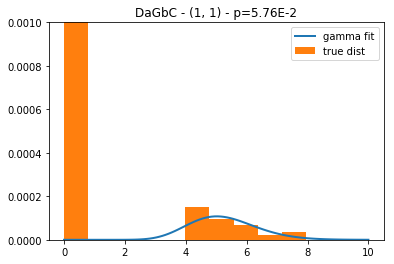

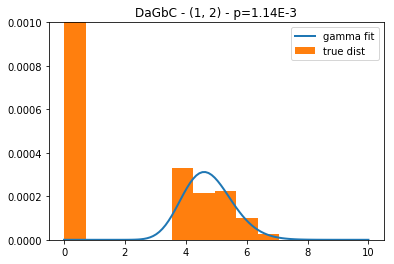

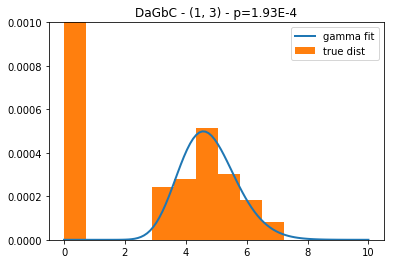

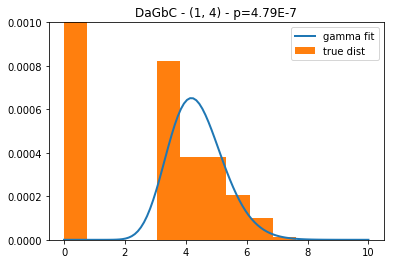

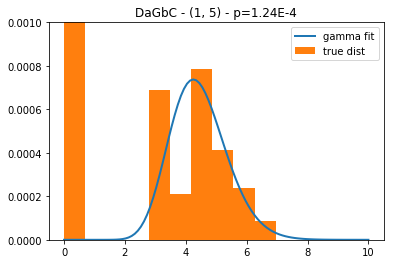

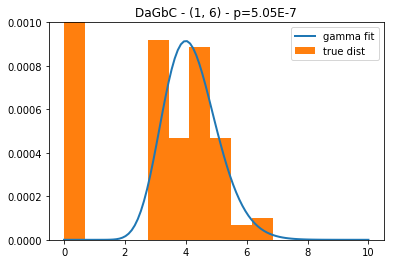

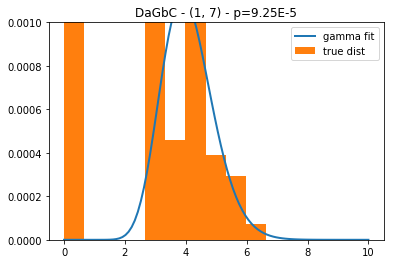

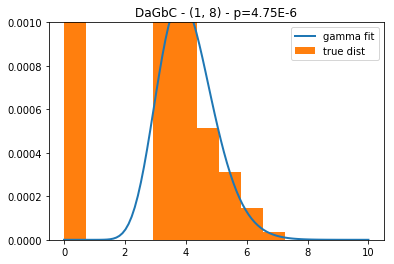

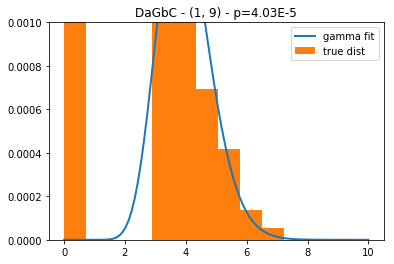

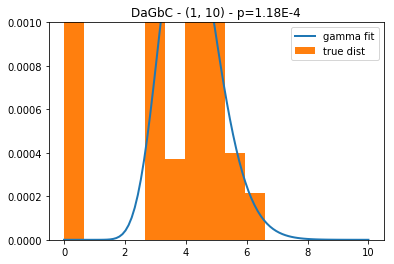

In [247]:
for degree_combo, dgp_values in list(perm_dgp.items())[:10]:
    ks_result = check_fit(dgp_values)
    p_value = decimal.Decimal(ks_result[1])
    plt.title(f'{metapath} - {degree_combo} - p={p_value :.2E}')